In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd

warnings.filterwarnings('ignore')

In [57]:
mae = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='MAE')
maemean = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='MAEMEAN')
rmse = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='RMSE')
mape = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='MAPE')
ppe_value = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='PPE(Value)')
ppe_time = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='PPE(Time)')

In [24]:
ppe_value.head()

,地區,ARIMA,LSTM,SIR
0,ARG,58433.88,26371.96,42402.920
1,MEX,8487.18,9439.95,8963.565
2,THA,4417.42,1477.71,2947.565
3,TWN,200.85,0.24,100.545
4,CHN,991.39,52.90,522.145


In [60]:
# Perform the repeated measures ANOVA
def anova(data: pd.DataFrame, index: str):
    # Melt the data
    melted_data = data.melt(id_vars=['地區'], value_vars=['ARIMA', 'LSTM', 'SIR'],
                                    var_name='Model', value_name=index)
    melted_data
    # Perform the repeated measures ANOVA
    anova_result = AnovaRM(data=melted_data, depvar=index, subject='地區', within=['Model']).fit()

    # Get the p-value
    p_value = anova_result.anova_table['Pr > F']['Model']
    print(f'p-value: {p_value}')
    return p_value, melted_data

# Perform the Tukey test
def tukey_test(data: pd.DataFrame, index: str):
    tukey_result = pairwise_tukeyhsd(endog=data[index], 
                                    groups=data['Model'], 
                                    alpha=0.1)

    print(tukey_result)

    return tukey_result

# Plot the data
def plot_tucky(tukey_result, index: str):
    # Create a DataFrame with the results
    results_df = pd.DataFrame({
        'Comparison': ['ARIMA-LSTM', 'ARIMA-SIR', 'LSTM-SIR'],
        'meandiff': tukey_result.meandiffs,
        'lower': tukey_result.confint[:, 0],
        'upper': tukey_result.confint[:, 1],
        'reject': tukey_result.reject
    })

    # Plot the results
    plt.figure(figsize=(8, 6))
    for i, row in enumerate(results_df.itertuples()):
        plt.plot([row.lower, row.upper], [i, i], marker='o', linestyle='-', color='royalblue')
        plt.text(row.upper + 0.5, i, row.Comparison, va='center', fontsize=10)

    # Add a vertical line at 0
    plt.axvline(0, color='green', linestyle='--')

    # Add labels
    plt.yticks(range(len(results_df)), results_df['Comparison'])
    plt.title(f"Tukey Simultaneous 90% CIs for {index}")
    plt.xlabel("Difference in Means")
    plt.ylabel("Group Comparisons")
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    plt.show()

Index: MAE
p-value: 0.005539891990547131
   Multiple Comparison of Means - Tukey HSD, FWER=0.10   
group1 group2 meandiff p-adj    lower      upper   reject
---------------------------------------------------------
 ARIMA   LSTM 1233.324 0.0779    67.8367 2398.8113   True
 ARIMA    SIR  616.662 0.5021  -548.8253 1782.1493  False
  LSTM    SIR -616.662 0.5021 -1782.1493  548.8253  False
---------------------------------------------------------


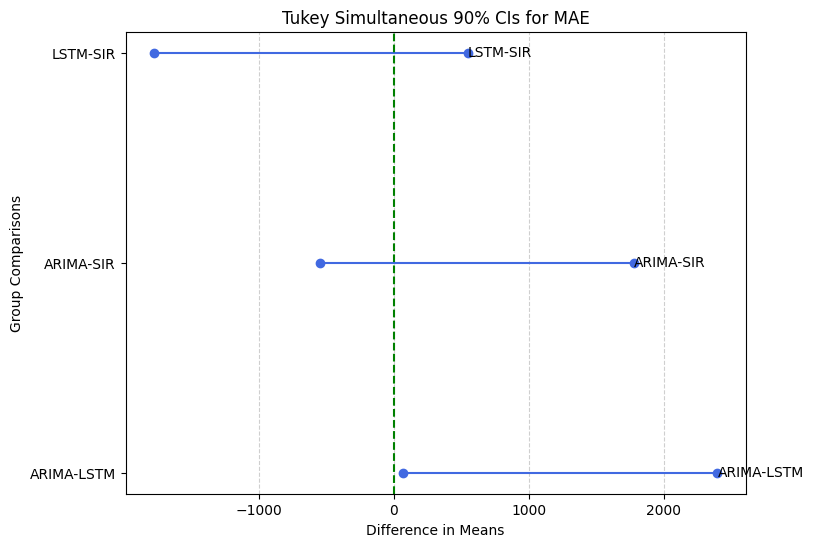



Index: MAEMEAN
p-value: 0.63210490224899


Index: RMSE
p-value: 0.043277970812179815
    Multiple Comparison of Means - Tukey HSD, FWER=0.10    
group1 group2  meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------
 ARIMA   LSTM   2359.533 0.2465  -722.7611 5441.8271  False
 ARIMA    SIR  1179.7665  0.694 -1902.5276 4262.0606  False
  LSTM    SIR -1179.7665  0.694 -4262.0606 1902.5276  False
-----------------------------------------------------------


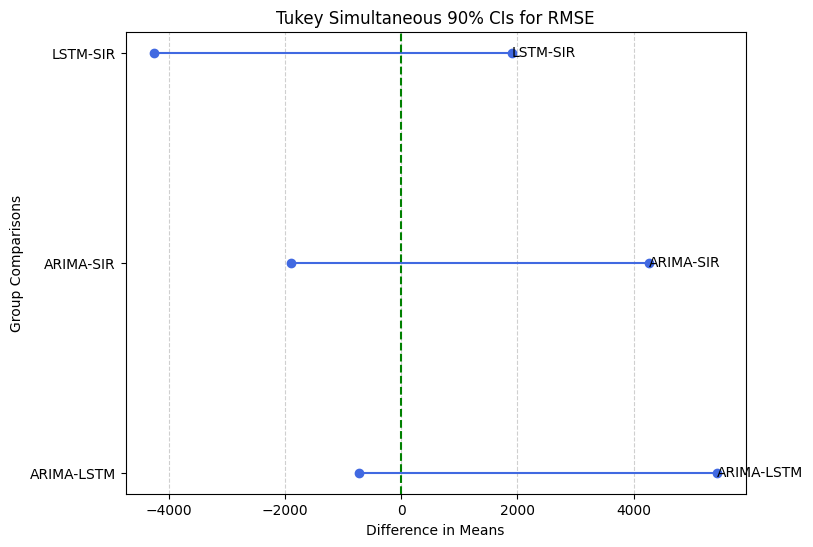



Index: MAPE
p-value: 0.13479830509240862


Index: PPE_Value
p-value: 0.9999337641470442


Index: PPE_Time
p-value: 6.284448433043933e-05
 Multiple Comparison of Means - Tukey HSD, FWER=0.10  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
 ARIMA   LSTM    -23.1 0.0004 -34.3079 -11.8921   True
 ARIMA    SIR   -11.55 0.0878 -22.7579  -0.3421   True
  LSTM    SIR    11.55 0.0878   0.3421  22.7579   True
------------------------------------------------------


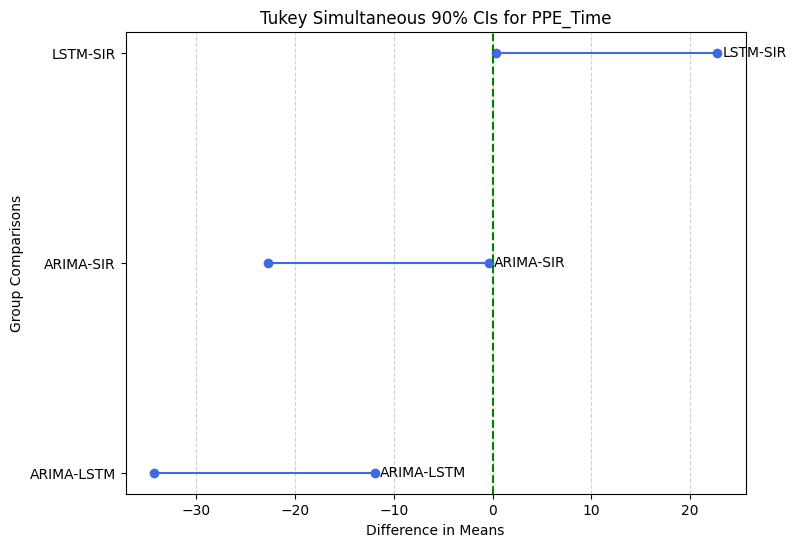

In [61]:
# Perform the ANOVA and Tukey test for each index
for index in ['MAE', 'MAEMEAN', 'RMSE', 'MAPE', 'PPE_Value', 'PPE_Time']:
    print(f'Index: {index}')
    p_value, melted_data = anova(data=eval(index.lower()), index=index)
    if p_value < 0.1:
        tukey_result = tukey_test(data=melted_data, index=index)
        plot_tucky(tukey_result, index=index)
    print('\n')
    